functions and packages needed

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
import math

### Section I: Implementing the AR Model

Recall that the negative log-likelihood function takes as input the parameter values and returns the negative log probability
of the observed data, under the assumption that those were the parameters used to generate the data.

For an AR(p) model, we have:

$$ NLL(\phi_1, \phi_2, \ldots, \phi_p, \sigma ~; x_1, x_2, \ldots, x_n) = \sum_{t=p+1}^n \left( \log \left( \sigma \sqrt{2 \pi} \right) + \frac{1}{2} \cdot \left( \frac{x_t - \left( \sum\limits_{i=1}^p \phi_i x_{t-i} \right)}{\sigma} \right)^2 \right) $$

In [39]:
class ARModel:
    """Class that implements an ARMA Model. Its functions are as follows:
    1. Maximum Likelihood estimation of parameters
    2. Inference/prediction of future states
    3. Data simulation
    """
    def __init__(self, p, data, p_params = None, sigma = None):
        """Initialize the network state
        @param p: the number of time steps to include in the AR process
        @param p_params: the initialization for the AR parameters
        """
        if (p_params is None):
            p_params = np.zeros(p)
        if (sigma is None):
            sigma = 1
            
        assert p == len(p_params)
        
        #assign parameter values
        self.p = p
        self.p_params = p_params
        self.sigma = sigma
        #store the data within the object
        self.data = data
    
    def loss(self, params):
        """
        params: array of parameters, elements 0:p = p_params, element p = sigma
        returns: loss
        """
        assert len(params) == self.p + 1
        N = self.data.shape[0]
        p_params = params[0:self.p]
        sigma = params[self.p]
        loss = 0
        
        #TODO: calculate the NLL of the data for the purposes of optimization and store it in loss
        if sigma<0:
            loss = np.inf
        else:
            loss=sum(np.log(sigma*(np.sqrt(2*np.pi)))+1/2*((self.data[t]-sum(p_params*np.flip(self.data[t-self.p:t])))/sigma)**2 for t in range(self.p, len(self.data)))
        
        return loss

    def fit(self):
        # Minimize the loss function, given the dataset
        params = np.concatenate((self.p_params, np.array([self.sigma])))
        res = minimize(self.loss, params, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
        self.p_params = res.x[0:self.p]
        self.sigma = res.x[self.p]
        
    def predict(self,data, N):
        """Method that predicts N timesteps in the future given input data
        @params data: p data points used to form the prediction
        @params N: number of time steps to predict in the future
        
        returns:
        prediction: predicted future value
        conf: variance of the estimated future value
        """
        assert len(data) == self.p
        prediction = np.zeros(N)
        conf = np.zeros(N)
        
        #TODO: predict N time steps in advance, given an input. 
        #The inference can be specific to your choice of p, no need to worry about general inference here
        avg = sum(self.data)/len(self.data)
        prediction = avg+self.p_params[0]**N*(data[0]-avg)
        conf = self.sigma**2*(1-self.p_params[0]**2)
        
        return prediction, conf
        
    def simulate(self,N):
        """Method that stimulates data given the p_params and q_params
        @param N: number of datapoints to simulate
        returns: N sampled datapoints
        """
        transient = 100 # length of time to run the simulation to wash out initial conditions
        w_t = self.sigma * np.random.normal(size = (N + transient,))
        x_t = np.zeros(N + transient)
        
        # TODO: generate data x_t given the parameters and white noise w_t
        x_t[0] = w_t[0]
        for i in range(1,N+transient):
            x_t[i] = self.p_params[0]*x_t[i-1]+w_t[i]
        
        return x_t[transient::] #discard the transient when returning simulated data    

### Section II: Fitting the AR Model

In this section, we will load some data from an unknown source, look at its ACF and PACF
plots to determine an appropriate AR(p) order, and fit the AR(p) model to the data to determine
the coefficients of the AR model as well as the standard deviation of the driving white noise process.

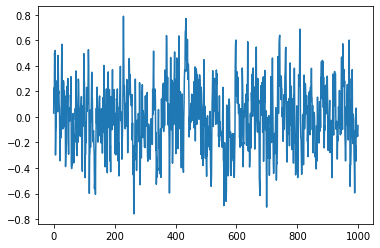

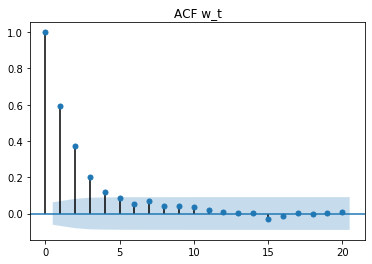

<Figure size 432x288 with 0 Axes>

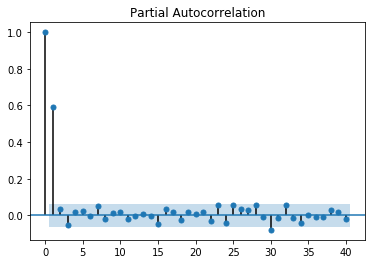

In [40]:
data = np.load("../../data/lab_2_data.npy")

#TODO: plot the acf of the data
lag = 20
plt.plot(data)
plot_acf(x=data, lags=lag, title="ACF w_t")
plt.show()

#TODO: plot the pacf of the data
plt.figure()
sm.graphics.tsa.plot_pacf(data, lags=40)
plt.show()

In [41]:
#TODO: choose a 'p' value, and fit the model
p = 1
data_fitter = ARModel(p, data, p_params = np.array([0.5]), sigma = 0.6) # set p_params and sigma to an educated guess for parameter values
data_fitter.fit()
print('lambda = ' + str(data_fitter.p_params))
print('sigma = ' + str(data_fitter.sigma))

Optimization terminated successfully.
         Current function value: -172.513313
         Iterations: 66
         Function evaluations: 129
lambda = [0.59225994]
sigma = 0.20359459913800762


### Section III: Simulating data

Now, we will use our fitted model to simulate a run of the AR model.

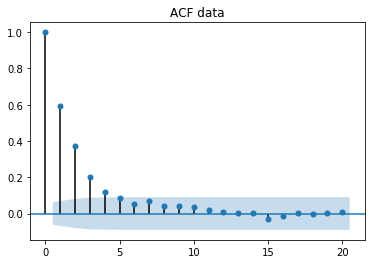

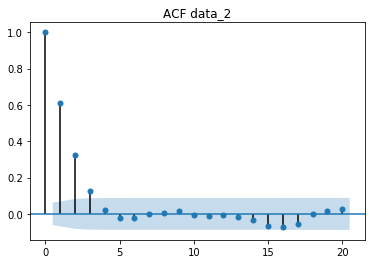

<Figure size 432x288 with 0 Axes>

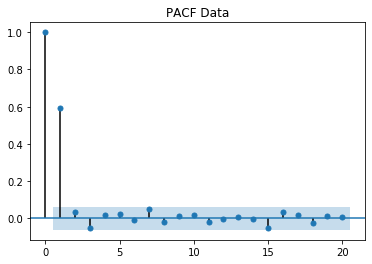

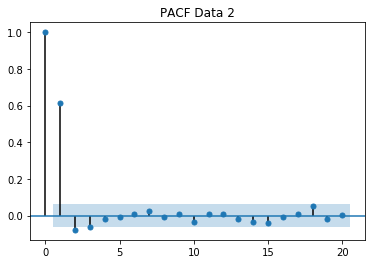

In [42]:
#TODO: generate 1000 samples from the fit model
data_2 = data_fitter.simulate(1000)

#TODO: Compare the ACF from the fit model to the data ACF
lag = 20

plot_acf(x=data, lags=lag, title="ACF data")
plot_acf(x=data_2, lags=lag, title="ACF data_2")
plt.show()

#TODO: Compare the PACF from the fit model to the data ACF
plt.figure()
sm.graphics.tsa.plot_pacf(data, lags=20)
plt.title('PACF Data')
sm.graphics.tsa.plot_pacf(data_2, lags=20)
plt.title('PACF Data 2')
plt.show()

### Section IV: Using the AR Model for prediction

Finally, we will use some of the provided data as a starting point and predict the next 20 values
based on our AR model's fitted parameters. This will be repeated for each of various starting points.

In [43]:
#TODO: for each of the given data points, generate predictions 20 time steps into the future
#plot the MSE bars of the estimate

data_prediction = data[0:100:25]
predictions = np.zeros((len(data_prediction), 20))
mse = np.zeros((len(data_prediction), 20))
for ii in range(0, len(data_prediction)):
    for jj in range(0,20):
        #for each data point, predict for each of 20 time steps
        predictions[ii,jj], mse[ii,jj] = data_fitter.predict(data_prediction[[ii]],jj)

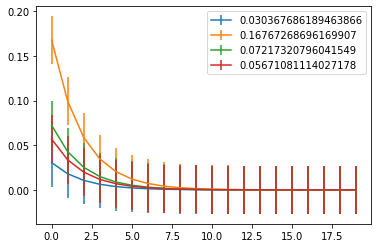

In [44]:
plt.figure()
for ii in range(0, len(data_prediction)):
    plt.errorbar(np.arange(0,20), predictions[ii,:], yerr = mse[ii,:])
plt.legend(data_prediction)
plt.show()